In [77]:
import torch
import pandas as pd
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [78]:
words = open('/Users/raghx/Desktop/Neural Networks/names.txt','r',).read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [79]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_length = len(itos)
      

In [80]:
#Dataset Creation
def build_dataset(words):
    X = []
    Y = []
    block_size = 3
    for w in words:
        context = [0] * block_size
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    return X,Y


In [81]:
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
X_tr,Y_tr = build_dataset(words[:n1])
X_val,Y_val = build_dataset(words[n1:n2])
X_test,Y_test = build_dataset(words[n2:])


In [145]:
n_embedding = 10
n_hidden = 200
block_size = 3 
g = torch.Generator().manual_seed(3332321)
C = torch.randn(((vocab_length,n_embedding)),generator=g)
w1 = torch.randn((n_embedding * block_size,n_hidden),generator=g) * ((2)/((n_embedding * block_size) ** 0.5))       # kamimi init for relu
b1 = torch.randn(n_hidden,generator=g) * 0.001
w2 = torch.randn((n_hidden,vocab_length),generator=g) * 0.01
b2 = torch.randn(vocab_length,generator=g) * 0
bn_gain = torch.ones(1,n_hidden)
bn_bias = torch.zeros(1,n_hidden)
bn_running_mean = torch.zeros(1,n_hidden)
bn_running_std = torch.ones(1,n_hidden)
params = [C,w1,b1,w2,b2,bn_bias,bn_gain]
print(sum(p.nelement() for p in params))
for p in params:
    p.requires_grad = True

12297


In [ ]:
#forward pass
batch_size = 32 
max_steps = 30000
loss_i =[]
momentum = 0.99
for k in range(max_steps):
    ikx = torch.randint(0,X_tr.shape[0],(batch_size,),generator=g)
    embd = C[X_tr[ikx]]
    a_pre_activation = embd.view(embd.shape[0],-1) @ w1 + b1
#batch normalization    
    meani =  a_pre_activation.mean(0,keepdim=True)
    stdi = a_pre_activation.std(0,keepdim=True)
    a_pre_activation = bn_gain * ((a_pre_activation - meani)/(0.00001 + stdi )) + bn_bias    
    with torch.no_grad():
        bn_running_mean = momentum * bn_running_mean + 0.01 * meani
        bn_running_std = momentum * bn_running_std + 0.01 * stdi
#activations for hidden layer
    a = torch.relu(a_pre_activation)
#Output layer    
    logits = a @ w2 + b2
    loss = F.cross_entropy(logits,Y_tr[ikx])
#backward pass
    for p in params:
        p.grad = None
    loss.backward()
    lr = 0.001 if k > 10000 else 0.1
    for p in params:
        p.data += -lr * p.grad

    if k % 5000 == 0:
        print(f'{k}/{max_steps}:{loss.item()}')

    loss_i.append(loss.item())


  

   

0/30000:3.297067165374756
5000/30000:2.1528611183166504
10000/30000:2.5738255977630615
15000/30000:2.1992268562316895
20000/30000:2.448018789291382
25000/30000:2.1391046047210693


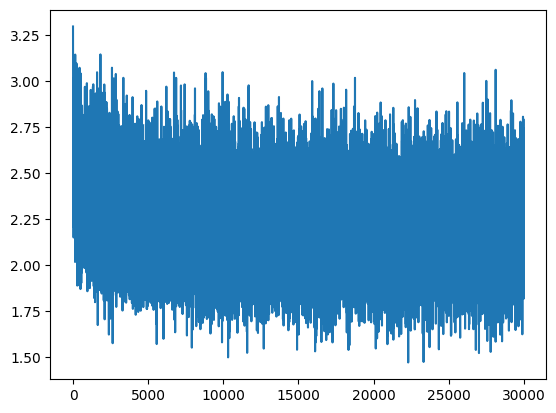

In [149]:
plt.plot(loss_i)

In [ ]:
#Inference 
@torch.no_grad()
def Split_loss(split):
    x,y = {
        'train': (X_tr,Y_tr),
        'val': (X_val,Y_val),
        'test': (X_test,Y_test)
    }[split]
    embd = C[x]
    a_pre_activation = embd.view(embd.shape[0],-1) @ w1 + b1
    a_pre_activation = bn_gain * ((a_pre_activation - bn_running_mean)/(0.00001 + bn_running_std)) + bn_bias
    a = torch.relu(a_pre_activation)
    logits = a @ w2 + b2
    loss = F.cross_entropy(logits,y)
    return loss.item()

print("Training loss",Split_loss('train'))
print("Validation loss",Split_loss('val'))





Training loss 2.1468417644500732
Validation loss 2.405622959136963


In [ ]:
# -> Original initial loss
# Training loss 25.325109481811523
# Validation loss 25.109655380249023

# -> after fixing initial loss by reducing bias and weights value for reducing output logits value
# Training loss 3.897186756134033
# Validation loss 3.88931941986084

# -> fixing tanh problem by reducing b1 and w1
# Training loss 2.1027655601501465
# Validation loss 2.3686301708221436